In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
#from pre_process import clean_LC,generate_representation
#from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw

#folder = "../../KOI_Data/"
folder = "KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


In [2]:
def impute_on_pandas(df):
    return df.fillna(df.median(),inplace=False)

df_meta = pd.read_csv(folder+"/kepler_dataset.csv")
all_labels = df_meta["NExScI Disposition"]
mask_conf = (all_labels=="CONFIRMED").values #entrenar al final con esstos?
mask_fp = (all_labels=="FALSE POSITIVE").values
mask_cand = (all_labels=="CANDIDATE").values

metadata_used = ["Period", "Duration", "Time of Transit Epoch", "r/R", "a/R",
                 "Inclination", "Limb Darkening Coeff1", "Limb Darkening Coeff2",
                 "Teq", "Fitted Stellar Density",
                "Teff","Stellar Radius", "Stellar Mass"]
df_meta["Duration"] = df_meta["Duration"]/24 #misma escala que time of transit epoch

df_meta_obj = df_meta[metadata_used]
mask_nan = pd.isna(df_meta_obj)

df_meta_obj = impute_on_pandas(df_meta_obj)

df_meta_obj.head()

,Period,Duration,Time of Transit Epoch,r/R,a/R,Inclination,Limb Darkening Coeff1,Limb Darkening Coeff2,Teq,Fitted Stellar Density,Teff,Stellar Radius,Stellar Mass
0,8.884923,0.086252,169.991686,0.114,36.466,89.89,0.497,0.204,770.0,11.62061,5332.0,0.843,0.821
1,5.092465,0.152458,357.535940,0.014,10.670,89.14,0.551,0.165,844.0,0.88510,5037.0,0.751,0.727
2,275.073650,0.140417,315.248600,0.014,512.000,89.93,0.437,0.243,303.0,33.55994,5604.0,1.187,0.864
3,8.460439,0.197288,133.774490,0.478,14.087,85.68,0.299,0.306,804.0,0.73874,5951.0,0.702,0.796
4,21.761298,0.051792,166.540438,0.032,137.070,89.95,0.627,0.108,486.0,102.86534,4859.0,0.720,0.781


In [3]:
#masacara sobre curvas de luz que tienen comportamiento de transito Mandel-Agol
mask_transit = np.load("data/mask_transit_LC.py") 
mask_transit
np.shape(mask_transit)

(8054,)

In [4]:
Y_transit = df_meta_obj.values[mask_transit]
Y_transit.shape

(4317, 13)

In [5]:
#pre-process: scale metadata
from sklearn.preprocessing import StandardScaler, RobustScaler
#scaler_meta = RobustScaler()
scaler_meta = StandardScaler()

Ystd_transit = scaler_meta.fit_transform(Y_transit)

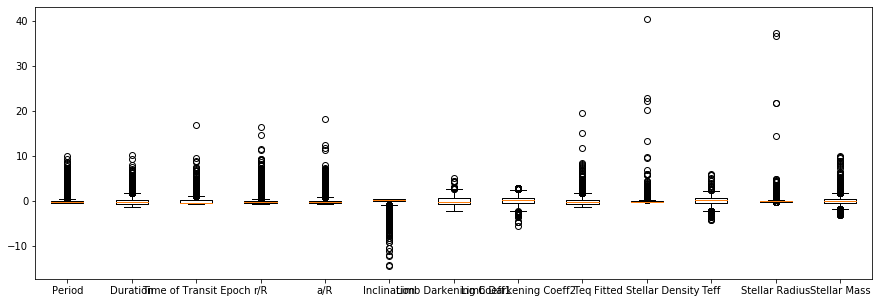

,Period,Duration,Time of Transit Epoch,r/R,a/R,Inclination,Limb Darkening Coeff1,Limb Darkening Coeff2,Teq,Fitted Stellar Density,Teff,Stellar Radius,Stellar Mass
count,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03,4.317000e+03
mean,-1.241691e-15,2.237137e-15,1.255012e-16,-1.021839e-14,-1.393424e-15,1.044820e-13,-6.799076e-14,2.228233e-14,-7.967271e-17,1.186990e-16,-6.298208e-17,-5.024550e-18,-3.768072e-15
std,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00,1.000116e+00
min,-5.099800e-01,-1.342305e+00,-7.408946e-01,-5.944392e-01,-6.771879e-01,-1.454917e+01,-2.152344e+00,-5.511046e+00,-1.310361e+00,-2.359379e-01,-4.267213e+00,-2.960257e-01,-3.220529e+00
25%,-4.378714e-01,-6.330545e-01,-4.702747e-01,-3.764355e-01,-4.955450e-01,-5.419423e-02,-7.657905e-01,-5.118920e-01,-5.996956e-01,-2.055943e-01,-4.732800e-01,-1.235059e-01,-5.141565e-01
50%,-3.326228e-01,-2.623250e-01,-3.798154e-01,-2.310997e-01,-3.158230e-01,2.991997e-01,-1.856014e-01,2.583705e-01,-1.899425e-01,-1.480966e-01,1.654492e-01,-8.585184e-02,-5.200273e-02
75%,-5.882125e-02,3.043375e-01,1.718955e-01,-1.309604e-02,6.238814e-02,4.564794e-01,6.010957e-01,6.812597e-01,3.126453e-01,-4.192620e-02,6.681527e-01,-2.555606e-02,3.657842e-01
max,1.011195e+01,1.025868e+01,1.679164e+01,1.653096e+01,1.819996e+01,5.050225e-01,5.055768e+00,2.976944e+00,1.956144e+01,4.037497e+01,5.940625e+00,3.732190e+01,1.005992e+01


In [6]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Ystd_transit)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.show()
aux_df = pd.DataFrame(Ystd_transit)
aux_df.columns = metadata_used
aux_df.describe()

### Create dataset

#### Representación Global Folded ya está generada y guardada

In [7]:
!ls data/

LC_global_200T.npy   LC_globalA_300T.npy   Time_global_300T.npy
LC_global_300T.npy   LC_globalA_400T.npy   Time_global_400T.npy
LC_global_400T.npy   LC_globalA_600T.npy   Time_global_600T.npy
LC_global_600T.npy   LC_globalA_900T.npy   Time_global_900T.npy
LC_global_900T.npy   mask_transit_LC.py
LC_globalA_200T.npy  Time_global_200T.npy


In [8]:
T = 200 #elegir cantidad de puntos en curva de luz

In [9]:
X_fold_lc = np.load("data/LC_global_%dT.npy"%T)     # curva de luz
X_fold_lc_aug = np.load("data/LC_globalA_%dT.npy"%T)# curva de luz dada vuelta (como data augmented)
X_fold_time = np.load("data/Time_global_%dT.npy"%T) # delta de los tiempos en la representacion de la curva luz
X_fold_lc.shape

(4317, 200)

### Escalar

In [10]:
def std_scaler(x):
    mu = np.nanmean(x, axis=-1, keepdims=True)
    std = np.nanstd(x, axis=-1, keepdims=True)+1e-9
    return (x- mu)/std

def set_scaler(x):
    return std_scaler(x)

for i in range(X_fold_lc.shape[0]):
    X_fold_lc[i] = set_scaler(X_fold_lc[i])
    X_fold_lc_aug[i] = set_scaler(X_fold_lc_aug[i])

In [11]:
X_data_t = np.concatenate([X_fold_time, X_fold_time], axis=0)
X_data = np.concatenate([X_fold_lc, X_fold_lc_aug], axis=0)

if Ystd_transit.shape[0] != X_data.shape[0]:
    Ystd_transit = np.tile(Ystd_transit, (2,1)) #utilizando data augmentation

X_data_t = np.expand_dims(X_data_t, axis=-1)
X_data = np.expand_dims(X_data, axis=-1)

print("X train shape: ",X_data.shape)
print("X train time shape: ",X_data_t.shape)
print("Y train shape: ",Ystd_transit.shape)

X train shape:  (8634, 200, 1)
X train time shape:  (8634, 200, 1)
Y train shape:  (8634, 13)


### Keras models

In [12]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

def plot_n_lc(real_lc, decoded_lc, n = 10):
    """ Funcion que sirve para comparar curvas de luz reales y predichas (reconstruccion)"""
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
        ax1.plot(real_lc[n_sampled], 'b.-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc[n_sampled], 'b.-')
        ax2.set_title("Reconstructed")
        plt.show()  

        plt.figure(figsize=(15,5))
        plt.plot(real_lc[n_sampled], 'bo-', label="Real")
        plt.plot(decoded_lc[n_sampled], 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [13]:
latent_dim = 32
_, T, channels = X_data.shape
D_dim = Ystd_transit.shape[1] #cantidad de valores en representacion condicional

## Regular VAE

In [14]:
def KL_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

#### IF THIS IS USED,, KL WEIGHT NEEDED TO BE LOW ######
def MSE_loss(y_true, y_pred):
    v = K.mean( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

#### HAS TO BE USED IN ORDER TO LEARN #######
def SSE_loss(y_true, y_pred):
    v = K.sum( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

def vae_loss(y_true, y_pred):
    l = 0.5
    return SSE_loss(y_true, y_pred) + l*KL_loss(y_true, y_pred)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_var) * epsilon

In [ ]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

#f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
#f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)

encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")


decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

#decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
#decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, MSE_loss])
vae.summary()


In [ ]:

batch_size = 128
vae.fit([X_data_t,X_data], X_data, epochs=200, batch_size=batch_size, validation_split=0.2)

In [ ]:
print("Errores ",vae.evaluate([X_data_t,X_data], X_data, batch_size=512))
X_data_hat = vae.predict([X_data_t,X_data], batch_size=512)
plot_n_lc(X_data[:,:,0], X_data_hat, n= 10) 

In [ ]:
## generate random
n = 20
z_sampleds = np.random.normal(0, 1, size=(n,1,latent_dim))
time_i = X_data_t[0][None,:,:] #el tiempo del primer dato para probar samples en eso

for i in range(n):
    x_decoded = generator.predict([time_i, z_sampleds[i]])

    plt.figure(figsize=(10,5))
    plt.plot(x_decoded[0,:], '.-')
    plt.show()
    
    
plt.figure(figsize=(10,5))
for i in range(n):    
    x_decoded = generator.predict([time_i, z_sampleds[i]])

    plt.plot(x_decoded[0,:], '.-')
plt.show()

## CONDITIONAL VAE
links que encontré:
* https://github.com/nnormandin/Conditional_VAE
* https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

# Conditional VAE (Patricio)

In [15]:
# Adding dimension to conditional values
Ystd_transit = np.expand_dims(Ystd_transit, axis=2)


In [16]:
# CVAE

x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")
y_lc = Input(shape = (D_dim, channels) , name ="Meta_inp")

x = concatenate([x_lc, x_t, y_lc],axis=1)

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
#f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional
z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)

encoder = Model([x_t, x_lc, y_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc, y_lc], z, name="encoder_sampling")


decoder_input = Input(shape=(latent_dim,), name="dc_inp")

decoder_reshape = Reshape((latent_dim,) + (1, ), input_shape=(latent_dim,) )(decoder_input)

#decoder_input2 = RepeatVector(T)(y_lc)

decode = Concatenate(axis=1)([x_t, decoder_reshape, y_lc]) #add time decode


#decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
#decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=False))(decode) #bidirectional

#decode = TimeDistributed(Dense(1, activation='linear'))(decode)
decode = Dense(T,activation='linear')(decode)
decode = Reshape((T,) + (1, ), input_shape=(T,) )(decode)
generator = Model([x_t, decoder_input, y_lc], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc,y_lc]), y_lc ])
vae = Model([x_t, x_lc, y_lc], out)

vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, MSE_loss])
vae.summary()








__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
Meta_inp (InputLayer)           (None, 13, 1)        0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 32)           107712      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
     

In [17]:
batch_size = 1000
vae.fit([X_data_t,X_data,Ystd_transit], X_data, epochs=50, batch_size=batch_size, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6907 samples, validate on 1727 samples
Epoch 1/50
6907/6907 [==============================] - 402s 58ms/step - loss: 199.2029 - KL_loss: 0.0156 - MSE_loss: 0.9960 - val_loss: 198.1969 - val_KL_loss: 0.0043 - val_MSE_loss: 0.9910
Epoch 2/50
6907/6907 [==============================] - 351s 51ms/step - loss: 195.2909 - KL_loss: 0.0038 - MSE_loss: 0.9764 - val_loss: 192.9018 - val_KL_loss: 0.0024 - val_MSE_loss: 0.9645
Epoch 3/50
6907/6907 [==============================] - 352s 51ms/step - loss: 184.1910 - KL_loss: 0.0040 - MSE_loss: 0.9209 - val_loss: 182.4901 - val_KL_loss: 0.0092 - val_MSE_loss: 0.9124
Epoch 4/50
6907/6907 [==============================] - 344s 50ms/step - loss: 167.5407 - KL_loss: 0.0074 - MSE_loss: 0.8377 - val_loss: 178.8344 - val_KL_loss: 0.0048 - val_MSE_loss: 0.8942
Epoch 5/50
6907/6907 [==============================] - 348s 50ms/step - loss: 160.5913 - KL_

6907/6907 [==============================] - 145s 21ms/step - loss: 136.2080 - KL_loss: 2.1099 - MSE_loss: 0.6758 - val_loss: 165.6029 - val_KL_loss: 2.2456 - val_MSE_loss: 0.8224
Epoch 41/50
6907/6907 [==============================] - 143s 21ms/step - loss: 136.3066 - KL_loss: 2.4369 - MSE_loss: 0.6754 - val_loss: 164.7213 - val_KL_loss: 2.6361 - val_MSE_loss: 0.8170
Epoch 42/50
6907/6907 [==============================] - 143s 21ms/step - loss: 135.9888 - KL_loss: 2.4478 - MSE_loss: 0.6738 - val_loss: 163.6164 - val_KL_loss: 2.5044 - val_MSE_loss: 0.8118
Epoch 43/50
6907/6907 [==============================] - 143s 21ms/step - loss: 135.7200 - KL_loss: 2.2889 - MSE_loss: 0.6729 - val_loss: 165.1278 - val_KL_loss: 2.5085 - val_MSE_loss: 0.8194
Epoch 44/50
6907/6907 [==============================] - 144s 21ms/step - loss: 135.8975 - KL_loss: 2.4314 - MSE_loss: 0.6734 - val_loss: 164.7972 - val_KL_loss: 2.7504 - val_MSE_loss: 0.8171
Epoch 45/50
6907/6907 [=============================

8634/8634 [==============================] - 57s 7ms/step
Errores  [140.9353032963735, 2.957706797197513, 0.697282212736542]


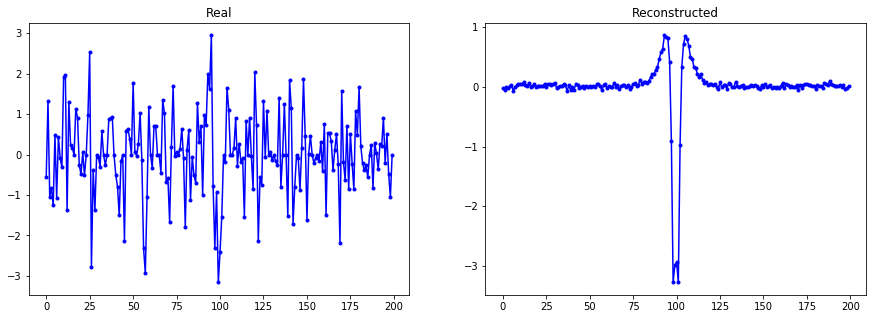

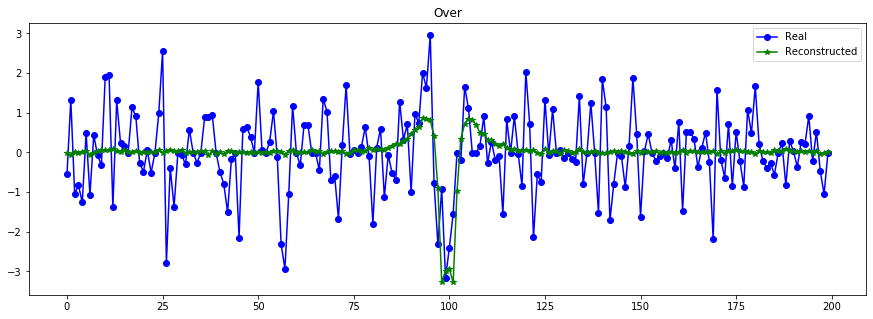

----------------------------------------------------------------


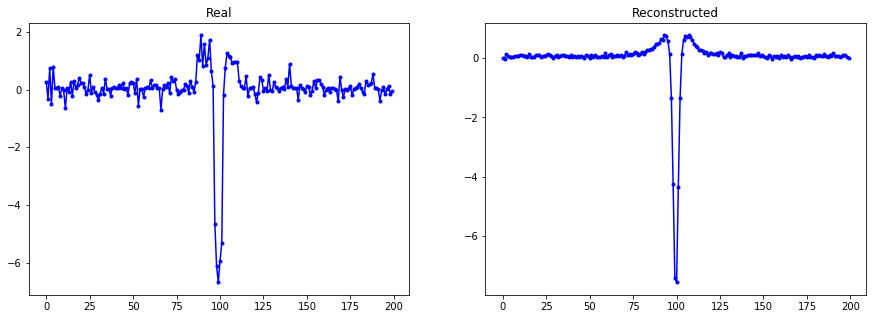

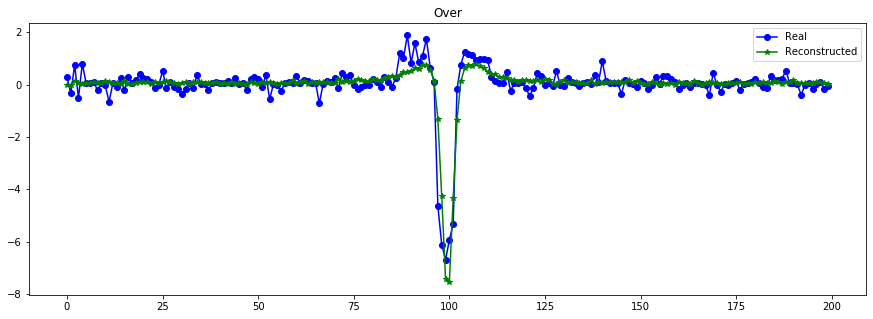

----------------------------------------------------------------


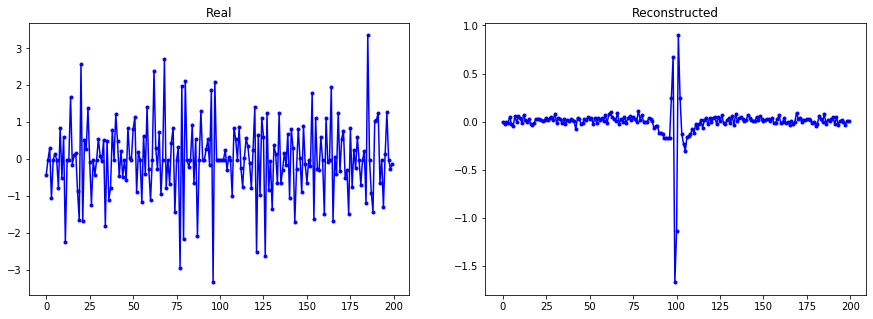

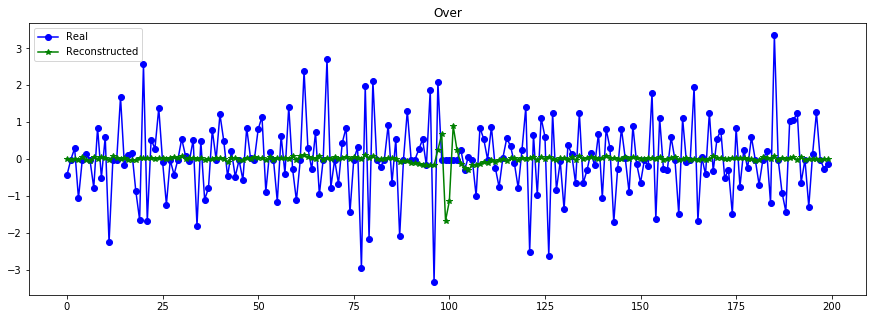

----------------------------------------------------------------


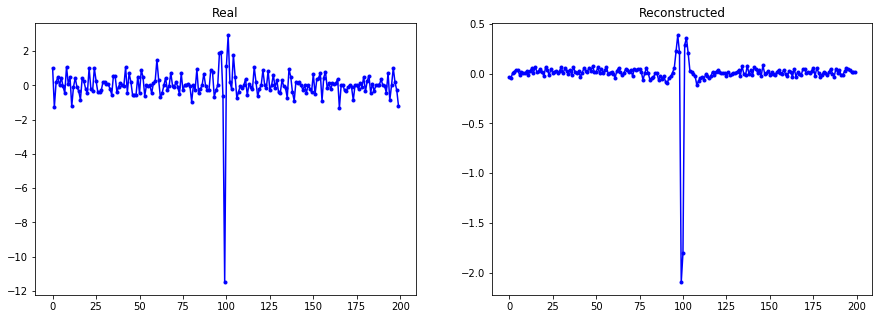

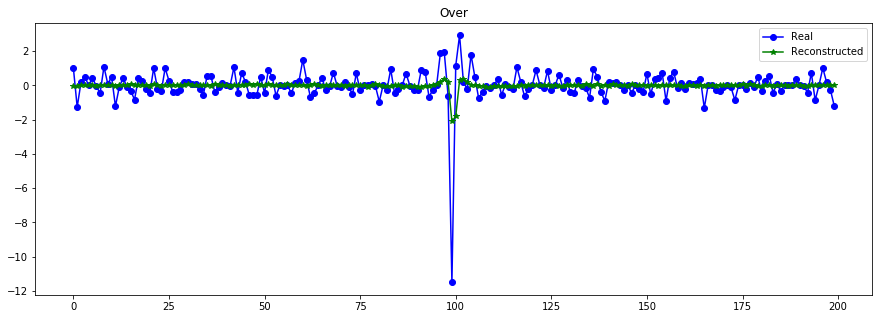

----------------------------------------------------------------


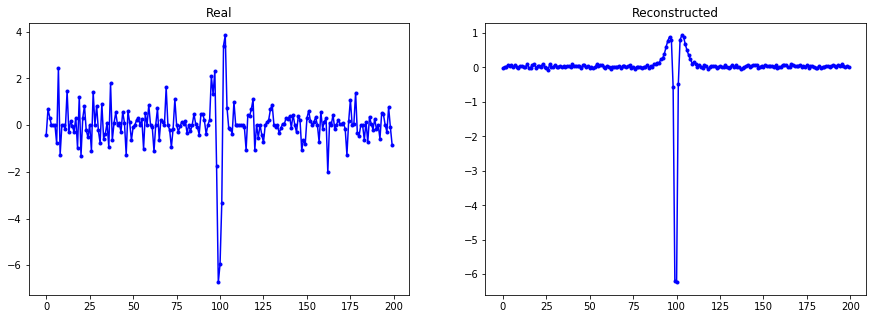

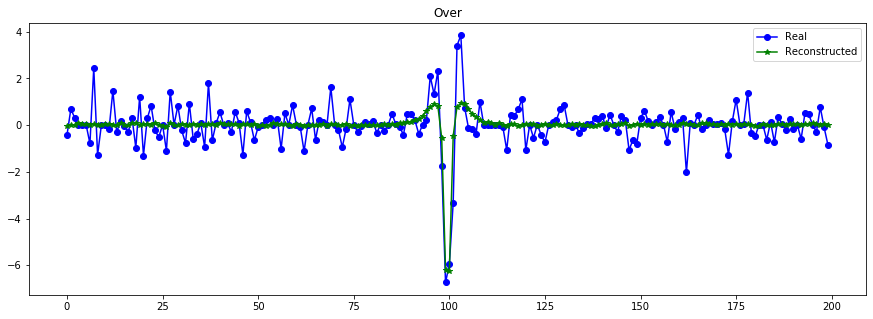

----------------------------------------------------------------


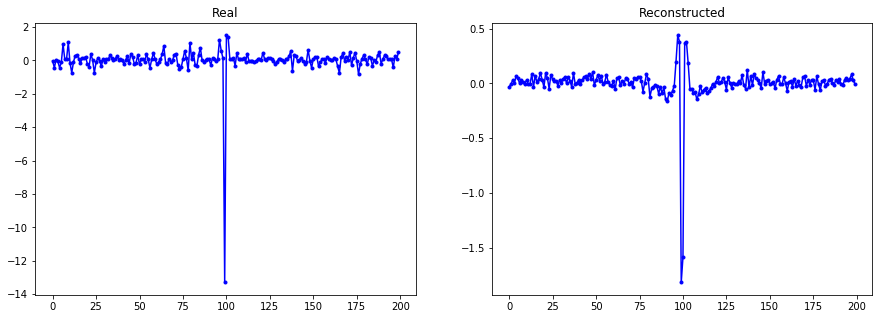

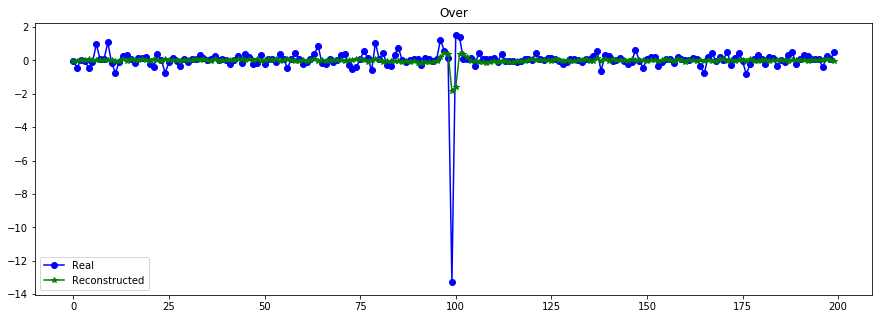

----------------------------------------------------------------


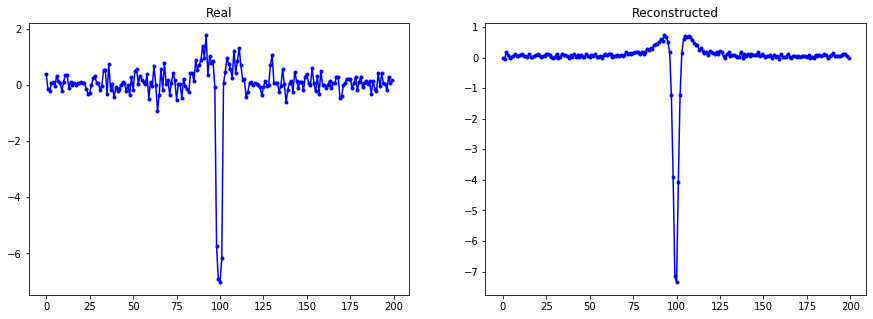

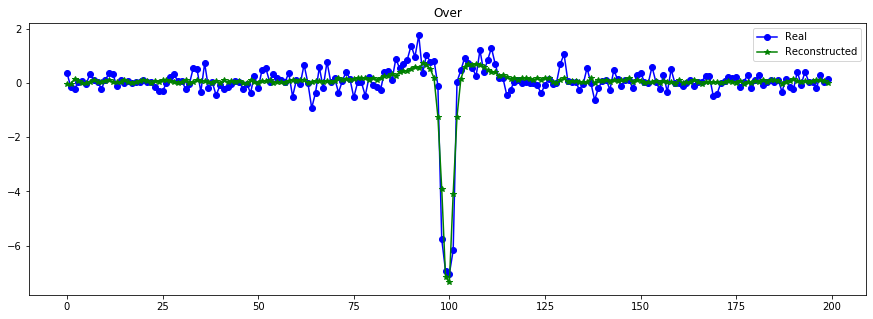

----------------------------------------------------------------


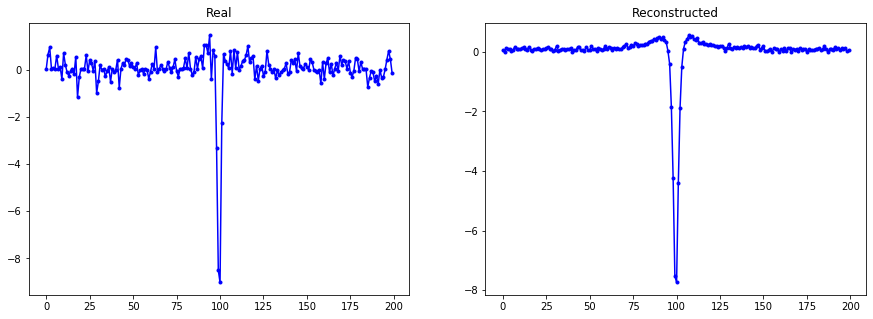

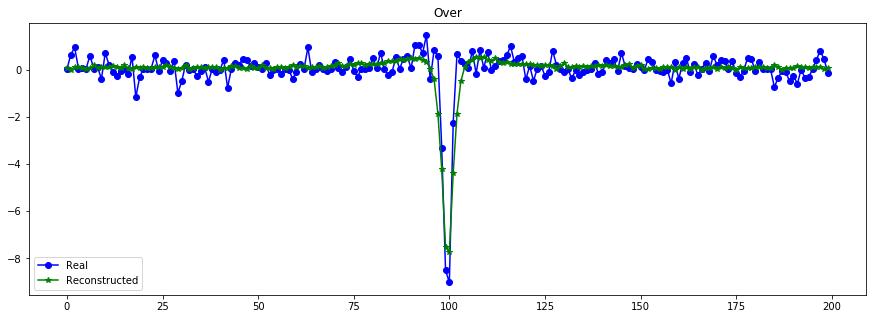

----------------------------------------------------------------


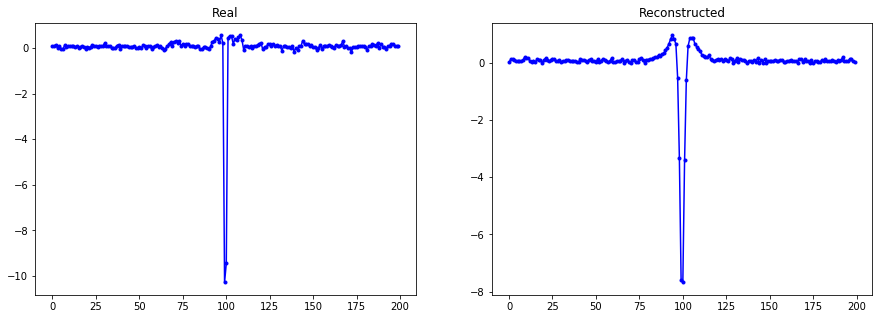

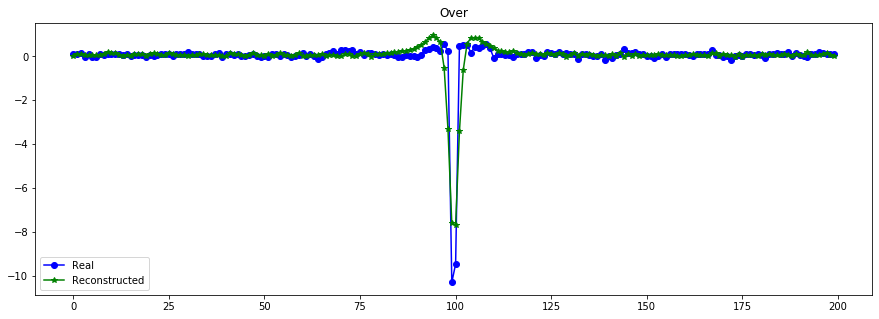

----------------------------------------------------------------


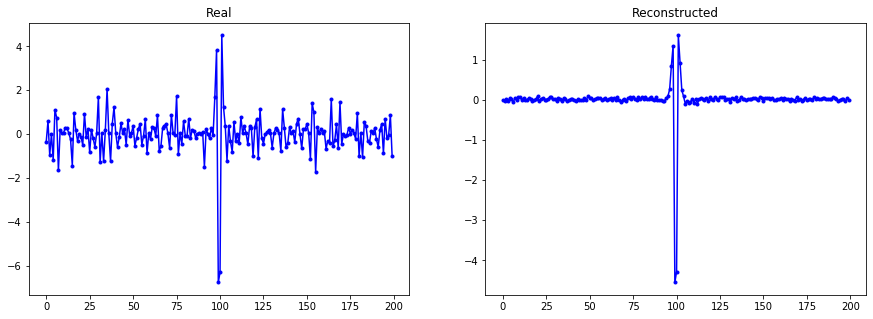

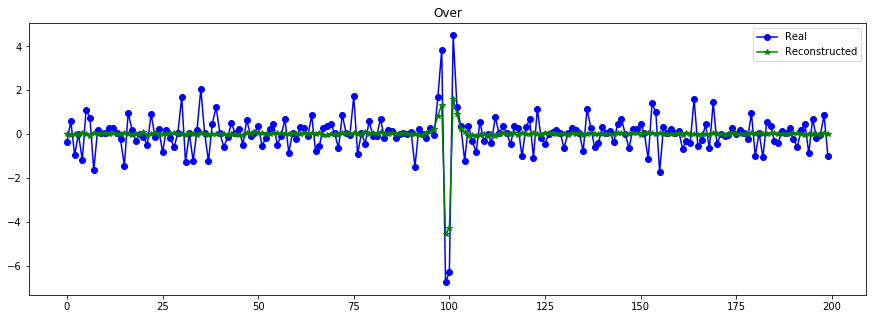

----------------------------------------------------------------


In [18]:
print("Errores ",vae.evaluate([X_data_t,X_data,Ystd_transit], X_data, batch_size=512))
X_data_hat = vae.predict([X_data_t,X_data,Ystd_transit], batch_size=512)
plot_n_lc(X_data[:,:,0], X_data_hat, n= 10) 